### Orchestrator-Worker
In the orchestrator-workers workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

When to use this workflow: This workflow is well-suited for complex tasks where you can’t predict the subtasks needed (in coding, for example, the number of files that need to be changed and the nature of the change in each file likely depend on the task). Whereas it’s topographically similar, the key difference from parallelization is its flexibility—subtasks aren't pre-defined, but determined by the orchestrator based on the specific input.

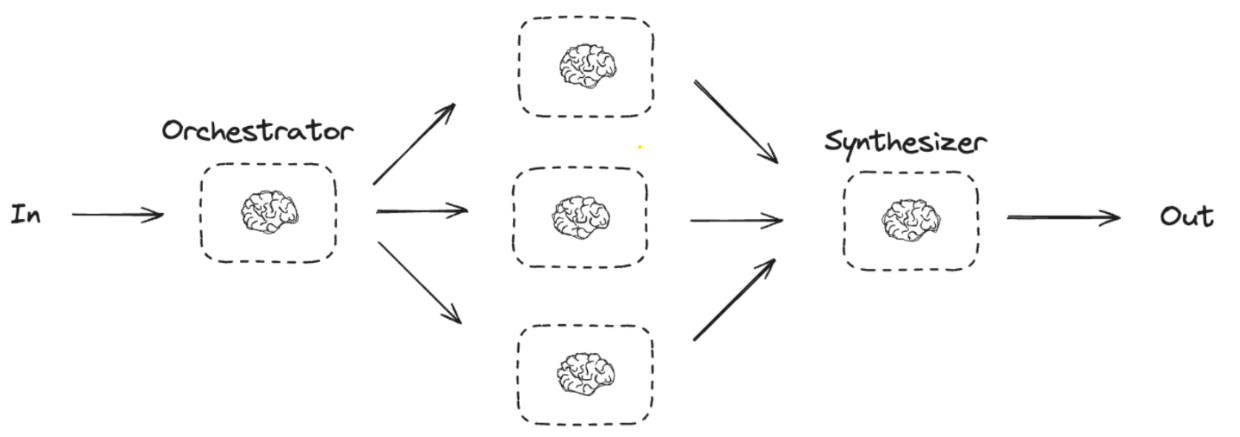

In [ ]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-qwq-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003788805, 'queue_time': 0.054086274000000004, 'total_time': 0.053788805}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_92412bc7e4', 'finish_reason': 'stop', 'logprobs': None}, id='run-9bbd43bc-fd97-40c5-8909-41e951c3b854-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [2]:
from typing import Annotated, List
import operator
from typing_extensions import Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage,SystemMessage
from typing_extensions import TypedDict

In [4]:
# Schema for structured output to use in planning
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief Overview of the main topics and concepts of the section")

class Sections(BaseModel):
    sections:List[Section]=Field(
        description="Sections of the report"
    )

# Augment the LLM with schema for structured output
planner=llm.with_structured_output(Sections)

### Creating Workers Dynamically In Langgraph 
Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [5]:
from langgraph.constants import Send


# Graph state
class State(TypedDict):
    topic: str  # Report topic
    sections: list[Section]  # List of report sections
    completed_sections: Annotated[
        list, operator.add
    ]  # All workers write to this key in parallel
    final_report: str  # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]


In [6]:
# Nodes
def orchestrator(state: State):
    """Orchestrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"Here is the report topic: {state['topic']}"),
        ]
    )

    print("Report Sections:",report_sections)

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker writes a section of the report"""

    # Generate section
    section = llm.invoke(
        [
            SystemMessage(
                content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting."
            ),
            HumanMessage(
                content=f"Here is the section name: {state['section'].name} and description: {state['section'].description}"
            ),
        ]
    )

    # Write the updated section to completed sections
    return {"completed_sections": [section.content]}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""

    # Kick off section writing in parallel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

def synthesizer(state: State):
    """Synthesize full report from sections"""

    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    return {"final_report": completed_report_sections}


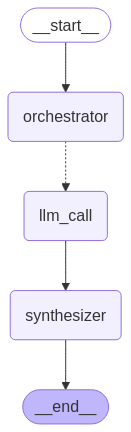

In [8]:
# Build workflow


from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
orchestrator_worker_builder = StateGraph(State)

# Add the nodes
orchestrator_worker_builder.add_node("orchestrator", orchestrator)
orchestrator_worker_builder.add_node("llm_call", llm_call)
orchestrator_worker_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchestrator_worker_builder.add_edge(START, "orchestrator")
orchestrator_worker_builder.add_conditional_edges(
    "orchestrator", assign_workers, ["llm_call"]
)
orchestrator_worker_builder.add_edge("llm_call", "synthesizer")
orchestrator_worker_builder.add_edge("synthesizer", END)

# Compile the workflow
orchestrator_worker = orchestrator_worker_builder.compile()

# Show the workflow
display(Image(orchestrator_worker.get_graph().draw_mermaid_png()))

In [9]:
# Invoke
state = orchestrator_worker.invoke({"topic": "Create a report on Agentic AI RAGs"})

from IPython.display import Markdown
Markdown(state["final_report"])

Report Sections: sections=[Section(name='Introduction to Agentic AI RAGs', description='An overview of what Agentic AI RAGs are, their purpose, and their significance in the field of artificial intelligence.'), Section(name='Technical Foundations of Agentic AI RAGs', description='A detailed explanation of the technical aspects that underpin Agentic AI RAGs, including algorithms, data requirements, and computational models.'), Section(name='Applications of Agentic AI RAGs', description='Discussion on the various applications of Agentic AI RAGs in different industries and their impact.'), Section(name='Challenges and Limitations', description='An analysis of the challenges and limitations associated with Agentic AI RAGs and potential solutions.'), Section(name='Future Prospects and Research Directions', description='Speculation on the future of Agentic AI RAGs, upcoming trends, and key areas for further research.')]


## Introduction to Agentic AI RAGs

Agentic AI RAGs, or Retrieval-Augmented Generation systems, represent a cutting-edge approach in the field of artificial intelligence that combines the strengths of retrieval and generation models. These systems are designed to retrieve relevant information from a large corpus and use this information to generate contextually appropriate and accurate responses. The purpose of Agentic AI RAGs is to enhance the ability of AI systems to handle complex, real-world queries by leveraging both stored knowledge and dynamic generation capabilities.

The significance of Agentic AI RAGs lies in their potential to address the limitations of traditional AI models. While retrieval models are adept at finding specific pieces of information within a dataset, they often fail to produce coherent and contextually rich responses. On the other hand, generation models can create natural and fluent text but may generate information inaccurately or out of context. By integrating these two paradigms, Agentic AI RAGs aim to provide more reliable, informative, and contextually relevant interactions, thus advancing the field of artificial intelligence in applications ranging from customer service to educational technology.

---

## Technical Foundations of Agentic AI RAGs

Agentic AI RAGs (Retrieval-Augmented Generation) systems are advanced AI architectures designed to enhance the performance and context-awareness of language models by integrating retrieval mechanisms for accessing external knowledge bases. The technical underpinnings of these systems can be categorized into several key components: retrieval algorithms, generation algorithms, data requirements, and computational models.

### Retrieval Algorithms

Retrieval algorithms in Agentic AI RAGs are responsible for finding and fetching relevant information from an external knowledge base. These algorithms are often based on vector similarity search techniques, such as cosine similarity, where documents or passages are represented as vectors in a high-dimensional space, and the system retrieves those that are closest to the query vector. More sophisticated retrieval models may utilize advanced techniques like BM25 (Okapi Best Match 25), which is a probabilistic retrieval model that takes into account term frequency and inverse document frequency.

### Generation Algorithms

The generation aspect of Agentic AI RAGs involves using the retrieved data to produce a coherent and contextually relevant response. This typically employs deep learning models, such as Transformer architectures, which are trained to generate text based on the input sequence and the retrieved context. The generation algorithm often incorporates an attention mechanism, allowing the model to focus on different parts of the retrieved context when producing the output sequence.

### Data Requirements

Data requirements for Agentic AI RAGs consist of both the training data for the generation model and the knowledge base for the retrieval system. The training data for the generation model typically includes a large corpus of text, such as books, articles, and web content, which is used to train the model to understand and generate human-like text. The knowledge base, on the other hand, needs to be comprehensive and relevant to the domain of application, containing structured or unstructured information that can be retrieved and used in the generation process.

### Computational Models

The computational models used in Agentic AI RAGs combine retrieval and generation techniques to provide robust and contextually accurate responses. This often involves a dual-stage process where the retrieval model first selects a subset of relevant documents or passages, and then the generation model uses this context to produce the final output. The integration of these models can be done at the architectural level, such as by concatenating the embeddings of the retrieved context with the input sequence before feeding it into the generation model, or through more complex mechanisms like multi-modal fusion.

In summary, the technical foundations of Agentic AI RAGs rely on the seamless integration of retrieval and generation technologies, supported by advanced algorithms and vast, rich datasets. These components collectively enable the AI to not only generate responses but also to draw upon external knowledge to enrich its outputs, making it particularly adept in applications requiring deep context understanding and information retrieval.

---

## Applications of Agentic AI RAGs

Agentic AI RAGs (Retrieval-Augmented Generation) have found diverse applications across various industries, enhancing efficiency, accuracy, and decision-making processes. In finance, these systems are used for sophisticated trading algorithms, risk assessment, and fraud detection, significantly improving the speed and accuracy of financial analysis. In healthcare, Agentic AI RAGs are employed for diagnostics, patient data analysis, and personalized treatment recommendations, contributing to improved patient outcomes.

In the realm of customer service, these AI systems provide advanced chatbot functionalities, offering 24/7 customer support with human-like interactions and quick issue resolution. Retail businesses leverage Agentic AI RAGs for inventory management, demand forecasting, and personalized marketing, leading to optimized supply chains and enhanced customer experiences. Additionally, the education sector uses these technologies to develop adaptive learning systems that tailor educational content to individual student needs, enhancing learning outcomes.

The integration of Agentic AI RAGs in these industries not only streamlines operations but also drives innovation, enabling businesses to stay competitive in their respective fields.

---

### Challenges and Limitations

Agentic AI RAGs (Retrieval-Augmented Generation) face several significant challenges and limitations, from data dependency and bias to operational complexities and ethical concerns. Addressing these issues is critical for the effective and responsible deployment of Agentic AI RAGs.

**Data Dependency and Quality**: Agentic AI RAGs rely heavily on the quality and diversity of data to generate accurate and meaningful responses. Poor data quality can lead to reduced performance, while a lack of diverse data can result in biased outputs. To mitigate this, continuous data curation and the inclusion of a diverse range of sources are necessary. Advanced techniques such as synthetic data generation can also be employed to enrich the data pool.

**Bias and Fairness**: One of the most pressing challenges is the potential for bias, where historical or systemic biases in the data are replicated by AI systems. Deploying bias detection algorithms and regular audits of the data and model outputs can help identify and mitigate these biases. Additionally, incorporating fairness metrics into the model evaluation process ensures that the AI RAGs are not only accurate but also fair.

**Explainability and Transparency**: The complexity of RAG models often makes it difficult to understand how decisions are made, leading to a lack of transparency. Efforts to improve explainability through techniques like model interpretability and transparency frameworks are crucial. Providing clear documentation and explanations of the decision-making process enhances user trust.

**Operational Complexity**: Integrating Agentic AI RAGs into existing systems can be technically challenging, requiring significant computational resources and sophisticated infrastructure. Simplifying integration processes, offering more modular AI solutions, and providing robust support and training can help overcome these operational hurdles.

**Ethical and Legal Concerns**: There are numerous ethical and legal considerations, particularly regarding privacy, informed consent, and the potential misuse of AI RAGs. Implementing strict data privacy practices and ensuring that ethical considerations are integrated into the design and deployment phases can address these concerns. Compliance with local and international regulations regarding AI usage is also essential.

**Scalability**: Scaling RAG systems without compromising on performance is a significant challenge. Optimizing the retrieval and generation processes and leveraging cloud-based architectures can enhance scalability. Continuous performance monitoring and model fine-tuning are necessary to maintain high standards as the systems scale.

**User Interaction Challenges**: Ensuring smooth and effective user interaction with AI RAGs involves addressing issues such as context understanding and natural language processing (NLP) capabilities. Enhancing the NLP algorithms and incorporating feedback mechanisms from users can improve the interaction experience over time.

Addressing these challenges through a combination of technological advancements, regulatory compliance, and continuous improvement efforts is vital for the successful implementation of Agentic AI RAGs.

---

### Future Prospects and Research Directions

The future of Agentic AI RAGs (Retrieval-Augmented Generation) promises significant advancements and novel applications, driven by ongoing research and technological innovation. Key areas of speculation include the development of more sophisticated and contextually aware retrieval mechanisms, which could drastically improve the efficiency and relevance of information provided by AI systems. Further, the integration of multi-modal data sources, such as audio, visual, and text, will likely become a central focus, aiming to create more versatile and human-like conversational agents.

In terms of upcoming trends, the move towards more personalized and adaptive learning algorithms for RAGs is expected to enable these systems to tailor their responses based on specific user interactions and preferences. This personalized approach could significantly enhance user experience and satisfaction. Additionally, the incorporation of ethical and fairness considerations into AI design will become increasingly critical, as these systems are deployed in a broader range of contexts, from healthcare to education.

Key areas for further research include enhancing the explainability of AI RAGs to ensure that the decision-making process of these systems is transparent and understandable to users. Another crucial area is the development of robust and secure data handling practices to protect user privacy and data integrity. Furthermore, the exploration of hybrid models that combine the strengths of both retrieval-based and generation-based approaches could lead to more powerful and flexible AI systems.

Overall, the future of Agentic AI RAGs is poised to be transformative, with ongoing research and development likely to unlock new capabilities and applications in various fields.

In [ ]:
## Blog Generation